# Setup

In [1]:
import torch
import pandas as pd
import numpy as np
import datetime
import os.path as osp
from torch_geometric.explain import Explainer, CaptumExplainer,ModelConfig,GNNExplainer
from torch_geometric.nn import SAGEConv, GATConv
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
data_folder = "../../data/processed/graph_data_nohubs/"
models_folder = "../../data/models/"
experiments_folder = "../../data/experiments/design_space_experiment/"

# Utility

In [3]:
import copy

def load_data(folder_path,load_test = False):
    if load_test:
        names = ["train","validation","test"]
    else:
        names = ["train","validation"]
    datasets = []
    for name in names:
        path = folder_path+name+".pt"
        datasets.append(torch.load(path))
    
    return datasets

def initialize_features(data,feature,dim,inplace=False):
    if inplace:
        data_object = data
    else:
        data_object = copy.copy(data)
    for nodetype, store in data_object.node_items():
        if feature == "random":
            data_object[nodetype].x = torch.rand(store["num_nodes"],dim)
        if feature == "ones":
            data_object[nodetype].x = torch.ones(store["num_nodes"],dim)
    return data_object

def save_model(model,folder_path,model_name):
    date = datetime.datetime.now()
    fdate = date.strftime("%d_%m_%y__")
    fname = f"{model_name}_{fdate}"
    torch.save(model.state_dict(), f"{folder_path}{fname}.pth")

In [4]:
path = data_folder+"split_dataset/"
original_train_data, original_val_data = load_data(path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Base model

In [28]:
import torch
from torch_geometric.nn import SAGEConv,GATConv, to_hetero
from torch_geometric.nn import HeteroDictLinear

class inner_product_decoder(torch.nn.Module):
    def forward(self,x_source,x_target,edge_index,apply_sigmoid=True):
        nodes_src = x_source[edge_index[0]]
        nodes_trg = x_target[edge_index[1]]
        pred = (nodes_src * nodes_trg).sum(dim=-1)

        if apply_sigmoid:
            pred = torch.sigmoid(pred)

        return pred

class base_message_layer(torch.nn.Module):

    def __init__(self, model_params,hidden_layer=True):
        super().__init__()

        # Currently SageConv or GATConv, might have to modify this to support other Convs
        conv_type = model_params["conv_type"]
        self.conv = layer_dict[conv_type]((-1,-1), model_params["hidden_channels"],aggr=model_params["micro_aggregation"],add_self_loops=False)
        self.normalize = model_params["L2_norm"]

        post_conv_modules = []
        if model_params["batch_norm"]:
            bn = torch.nn.BatchNorm1d(model_params["hidden_channels"])
            post_conv_modules.append(bn)
        
        if model_params["dropout"] > 0:    
            dropout = torch.nn.Dropout(p=model_params["dropout"])
            post_conv_modules.append(dropout)
        
        # No activation on final embedding layer
        if hidden_layer:
            activation = model_params["activation"]()
            post_conv_modules.append(activation)
        
        self.post_conv = torch.nn.Sequential(*post_conv_modules)

    def forward(self, x:dict, edge_index:dict) -> dict:
        x = self.conv(x,edge_index)
        x = self.post_conv(x)
        if self.normalize:
            x = torch.nn.functional.normalize(x,2,-1)
        return x

class multilayer_message_passing(torch.nn.Module):
    #TODO: consider input and output dims with skipcat. Currently the two supported convs auto-detect dimensions. Might have to modify this if i add more convs in the future.
    def __init__(self,num_layers,model_params,metadata):
        super().__init__()

        self.skip = model_params["layer_connectivity"]
        self.num_layers = num_layers

        for i in range(self.num_layers):
            hidden_layer = i != self.num_layers-1
            layer = to_hetero(base_message_layer(model_params,hidden_layer),metadata,model_params["macro_aggregation"])
            self.add_module(f"Layer_{i}",layer)
    
    def hetero_skipsum(self,out: dict, identity:dict) -> dict:
        x_transformed = {}
        for key,out_val in out.items():
            identity_val = identity[key]
            transformed_val = out_val + identity_val
            x_transformed[key] = transformed_val

        return x_transformed

    def hetero_skipcat(self,x: dict, x_i:dict) -> dict:
        x_transformed = {}
        for key,x_val in x.items():
            x_i_val = x_i[key]
            transformed_val = torch.cat([x_val,x_i_val],dim=-1)
            x_transformed[key] = transformed_val

        return x_transformed  
    
    def forward(self, x:dict, edge_index:dict) -> dict:
        for i, layer in enumerate(self.children()):
            identity = x
            out = layer(x,edge_index)
            if self.skip == "skipsum":
                out = self.hetero_skipsum(out,identity)
            elif self.skip == "skipcat" and i < self.num_layers -1:
                out = self.hetero_skipcat(out,identity)
        
        return out 


class MLP(torch.nn.Module):
    def __init__(self,num_layers,in_dim,out_dim,model_params,hidden_dim=None):
        super().__init__()

        hidden_dim = out_dim if hidden_dim is None else hidden_dim
        
        modules = []
        if num_layers == 1:
            if in_dim == -1:
                modules.append(torch.nn.LazyLinear(out_dim))
            else:
                modules.append(torch.nn.Linear(in_dim,hidden_dim))
        else:
            for i in range(num_layers):
                final_layer = i == num_layers-1
                first_layer = i == 0
                if first_layer:
                    if in_dim == -1:
                        modules.append(torch.nn.LazyLinear(hidden_dim))
                        modules.append(model_params["activation"]())
                    else:
                        modules.append(torch.nn.Linear(in_dim,hidden_dim))
                        modules.append(model_params["activation"]())                        
                elif final_layer:
                    modules.append(torch.nn.Linear(hidden_dim,out_dim))
                else:
                    modules.append(torch.nn.Linear(hidden_dim,hidden_dim))
                    modules.append(model_params["activation"]())
        
        self.model = torch.nn.Sequential(*modules)
    
    def forward(self,x):
        x = self.model(x)
        return x


class base_encoder(torch.nn.Module):
    def __init__(self,model_params,metadata):
        super().__init__()

        self.has_pre_mlp = model_params["pre_process_layers"] > 0
        self.has_post_mlp = model_params["post_process_layers"] > 0

        if self.has_pre_mlp:
            self.pre_mlp = to_hetero(MLP(model_params["pre_process_layers"],-1,model_params["hidden_channels"],model_params),metadata)
        
        self.message_passing = multilayer_message_passing(model_params["msg_passing_layers"],model_params,metadata)

        if self.has_post_mlp:
            self.post_mlp = to_hetero(MLP(model_params["post_process_layers"],model_params["hidden_channels"],model_params["hidden_channels"],model_params),metadata)
    
    def forward(self,x:dict,edge_index:dict) -> dict :
        if self.has_pre_mlp:
            x = self.pre_mlp(x)

        x = self.message_passing(x,edge_index)
        
        if self.has_post_mlp:
            x = self.post_mlp(x)

        return x

class base_model(torch.nn.Module):
    def __init__(self, model_params,metadata):
        super().__init__()

        default_model_params = {
            "hidden_channels":32,
            "conv_type":"SAGEConv",
            "batch_norm": True,
            "dropout":0,
            "activation":torch.nn.LeakyReLU,
            "micro_aggregation":"mean",
            "macro_aggregation":"mean",
            "layer_connectivity":None,
            "L2_norm":False,
            "feature_dim": 10,
            "pre_process_layers":0,
            "msg_passing_layers":2,
            "post_process_layers":0,
        }
        
        for arg in default_model_params:
            if arg not in model_params:
                model_params[arg] = default_model_params[arg]
        
        self.encoder = base_encoder(model_params,metadata)
        self.decoder = inner_product_decoder()
        self.loss_fn = torch.nn.BCELoss()
    
    def decode(self,x:dict,edge_label_index:dict,supervision_types):
        pred_dict = {}
        for edge_type in supervision_types:
            edge_index = edge_label_index[edge_type]

            src_type = edge_type[0]
            trg_type = edge_type[2]

            x_src = x[src_type]
            x_trg = x[trg_type]

            pred = self.decoder(x_src,x_trg,edge_index)

            pred_dict[edge_type] = pred
        
        return pred_dict
    
    def encode(self,data):
        x = data.x_dict
        adj_t = data.adj_t_dict
        edge_index = data.edge_index_dict

        encodings = self.encoder(x,adj_t)
        return encodings
    
    def forward(self,data,supervision_types):
        x = data.x_dict
        adj_t = data.adj_t_dict
        edge_index = data.edge_index_dict
        edge_label_index = data.edge_label_index_dict

        x = self.encoder(x,adj_t)
        pred = self.decode(x,edge_label_index,supervision_types)
        return pred
    
    def loss(self, prediction_dict, label_dict):
        loss = 0
        num_types = len(prediction_dict.keys())
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss/num_types

layer_dict = {
    "GATConv":GATConv,
    "SAGEConv":SAGEConv
}

# Base_model 2.0

In [49]:
import torch
from torch_geometric.nn import SAGEConv,GATConv, to_hetero

class inner_product_decoder(torch.nn.Module):
    def forward(self,x_source,x_target,edge_index,apply_sigmoid=True):
        nodes_src = x_source[edge_index[0]]
        nodes_trg = x_target[edge_index[1]]
        pred = (nodes_src * nodes_trg).sum(dim=-1)

        if apply_sigmoid:
            pred = torch.sigmoid(pred)

        return pred

class base_message_layer(torch.nn.Module):

    def __init__(self, model_params,hidden_layer=True):
        super().__init__()

        # Currently SageConv or GATConv, might have to modify this to support other Convs
        conv_type = model_params["conv_type"]
        self.conv = layer_dict[conv_type]((-1,-1), model_params["hidden_channels"],aggr=model_params["micro_aggregation"],add_self_loops=False)
        self.normalize = model_params["L2_norm"]

        post_conv_modules = []
        if model_params["batch_norm"]:
            bn = torch.nn.BatchNorm1d(model_params["hidden_channels"])
            post_conv_modules.append(bn)
        
        if model_params["dropout"] > 0:    
            dropout = torch.nn.Dropout(p=model_params["dropout"])
            post_conv_modules.append(dropout)
        
        # No activation on final embedding layer
        if hidden_layer:
            activation = model_params["activation"]()
            post_conv_modules.append(activation)
        
        self.post_conv = torch.nn.Sequential(*post_conv_modules)

    def forward(self, x:dict, edge_index:dict) -> dict:
        x = self.conv(x,edge_index)
        x = self.post_conv(x)
        if self.normalize:
            x = torch.nn.functional.normalize(x,2,-1)
        return x

# class multilayer_message_passing(torch.nn.Module):
#     #TODO: consider input and output dims with skipcat. Currently the two supported convs auto-detect dimensions. Might have to modify this if i add more convs in the future.
#     def __init__(self,num_layers,model_params):
#         super().__init__()

#         self.skip = model_params["layer_connectivity"]
#         self.num_layers = num_layers

#         for i in range(self.num_layers):
#             hidden_layer = i != self.num_layers-1
#             layer = base_message_layer(model_params,hidden_layer)
#             self.add_module(f"Layer_{i}",layer)
    
#     def forward(self, x:dict, edge_index:dict) -> dict:
#         for i, layer in enumerate(self.children()):
#             identity = x
#             out = layer(x,edge_index)
#             if self.skip == "skipsum":
#                 out += identity
#             elif self.skip == "skipcat" and i < self.num_layers -1:
#                 out = torch.cat([out,identity],dim=-1)
        
#         return out 

class multilayer_message_passing(torch.nn.Module):
    #TODO: consider input and output dims with skipcat. Currently the two supported convs auto-detect dimensions. Might have to modify this if i add more convs in the future.
    def __init__(self,num_layers,model_params):
        super().__init__()

        self.skip = model_params["layer_connectivity"]
        self.num_layers = num_layers
        self.normalize = model_params["L2_norm"]
        self.batch_norm = model_params["batch_norm"]
        self.droput = model_params["dropout"]

        for i in range(self.num_layers):
            hidden_layer = i != self.num_layers-1
            layer = base_message_layer(model_params,hidden_layer)
            self.add_module(f"Layer_{i}",layer)
    
    def forward(self, x:dict, edge_index:dict) -> dict:
        for i, layer in enumerate(self.children()):
            identity = x
            out = layer(x,edge_index)
            if self.skip == "skipsum":
                out += identity
            elif self.skip == "skipcat" and i < self.num_layers -1:
                out = torch.cat([out,identity],dim=-1)
        
        return out 


class MLP(torch.nn.Module):
    def __init__(self,num_layers,in_dim,out_dim,activate_last,hidden_dim=None):
        super().__init__()

        hidden_dim = out_dim if hidden_dim is None else hidden_dim
        
        modules = []
        if num_layers == 1:
            if in_dim == -1:
                modules.append(torch.nn.LazyLinear(out_dim))
            else:
                modules.append(torch.nn.Linear(in_dim,hidden_dim))
        else:
            for i in range(num_layers):
                final_layer = i == num_layers-1
                first_layer = i == 0
                if first_layer:
                    if in_dim == -1:
                        modules.append(torch.nn.LazyLinear(hidden_dim))
                        modules.append(torch.nn.LeakyReLU())
                    else:
                        modules.append(torch.nn.Linear(in_dim,hidden_dim))
                        modules.append(torch.nn.LeakyReLU())                        
                elif final_layer:
                    modules.append(torch.nn.Linear(hidden_dim,out_dim))
                else:
                    modules.append(torch.nn.Linear(hidden_dim,hidden_dim))
                    modules.append(torch.nn.LeakyReLU())
        
        if activate_last:
            modules.append(torch.nn.LeakyReLU())
        
        self.model = torch.nn.Sequential(*modules)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def forward(self,x):
        x = self.model(x)
        return x
    

class hetero_MLP(torch.nn.Module):
    def __init__(self,model_params,metadata,layer_type):
        super().__init__()

        node_types = metadata[0]
        if layer_type == "pre_mlp":
            self.in_dim = -1
            self.num_layers = model_params["pre_process_layers"]
            self.activate_last = True
            
        elif layer_type == "post_mlp":
            self.in_dim = model_params["hidden_channels"]
            self.num_layers = model_params["post_process_layers"]
            self.activate_last = False
        
        self.out_dim = model_params["hidden_channels"]
        self.mlps = torch.nn.ModuleDict({})

        for node_type in node_types:
            self.mlps[node_type] = MLP(self.num_layers,self.in_dim,self.out_dim,self.activate_last)
    
    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        for mlp in self.mlps.values():
            mlp.reset_parameters()
        
    def forward(self,x:dict):
        out_dict = {}
        for key, mlp in self.mlps.items():
            if key in x:
                out_dict[key] = mlp(x[key])
        return out_dict

class base_encoder(torch.nn.Module):
    def __init__(self,model_params,metadata):
        super().__init__()

        self.has_pre_mlp = model_params["pre_process_layers"] > 0
        self.has_post_mlp = model_params["post_process_layers"] > 0

        if self.has_pre_mlp:
            self.pre_mlp = hetero_MLP(model_params,metadata,"pre_mlp")
        
        self.message_passing = to_hetero(multilayer_message_passing(model_params["msg_passing_layers"],model_params),metadata,aggr=model_params["macro_aggregation"])

        if self.has_post_mlp:
            self.post_mlp = hetero_MLP(model_params,metadata,"post_mlp")
    
    def forward(self,x:dict,edge_index:dict) -> dict :
        if self.has_pre_mlp:
            x = self.pre_mlp(x)

        x = self.message_passing(x,edge_index)
        
        if self.has_post_mlp:
            x = self.post_mlp(x)

        return x

class base_model(torch.nn.Module):
    def __init__(self, model_params,metadata):
        super().__init__()

        default_model_params = {
            "hidden_channels":32,
            "conv_type":"SAGEConv",
            "batch_norm": True,
            "dropout":0,
            "activation":torch.nn.LeakyReLU,
            "micro_aggregation":"mean",
            "macro_aggregation":"mean",
            "layer_connectivity":None,
            "L2_norm":False,
            "feature_dim": 10,
            "pre_process_layers":0,
            "msg_passing_layers":2,
            "post_process_layers":0,
        }
        
        for arg in default_model_params:
            if arg not in model_params:
                model_params[arg] = default_model_params[arg]
        
        self.encoder = base_encoder(model_params,metadata)
        self.decoder = inner_product_decoder()
        self.loss_fn = torch.nn.BCELoss()
    
    def decode(self,x:dict,edge_label_index:dict,supervision_types):
        pred_dict = {}
        for edge_type in supervision_types:
            edge_index = edge_label_index[edge_type]

            src_type = edge_type[0]
            trg_type = edge_type[2]

            x_src = x[src_type]
            x_trg = x[trg_type]

            pred = self.decoder(x_src,x_trg,edge_index)

            pred_dict[edge_type] = pred
        
        return pred_dict
    
    def encode(self,data):
        x = data.x_dict
        adj_t = data.adj_t_dict
        edge_index = data.edge_index_dict

        encodings = self.encoder(x,adj_t)
        return encodings
    
    def forward(self,data,supervision_types):
        x = data.x_dict
        adj_t = data.adj_t_dict
        edge_index = data.edge_index_dict
        edge_label_index = data.edge_label_index_dict

        x = self.encoder(x,adj_t)
        pred = self.decode(x,edge_label_index,supervision_types)
        return pred
    
    def loss(self, prediction_dict, label_dict):
        loss = 0
        num_types = len(prediction_dict.keys())
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss/num_types

layer_dict = {
    "GATConv":GATConv,
    "SAGEConv":SAGEConv
}

In [50]:
model_params = {
            "hidden_channels":32,
            "conv_type":"SAGEConv",
            "batch_norm": True,
            "dropout":0.1,
            "activation":torch.nn.LeakyReLU,
            "micro_aggregation":"sum",
            "macro_aggregation":"mean",
            "layer_connectivity":None,
            "L2_norm":True,
            "feature_dim": 10,
            "pre_process_layers":2,
            "msg_passing_layers":2,
            "post_process_layers":2,
        }

dblp_model = base_model(model_params,train_data.metadata())

In [56]:
dblp_model(train_data,[('author', 'to', 'paper')])

AttributeError: 'NoneType' object has no attribute 'dim'

In [51]:
dblp_model

base_model(
  (encoder): base_encoder(
    (pre_mlp): hetero_MLP(
      (mlps): ModuleDict(
        (author): MLP(
          (model): Sequential(
            (0): LazyLinear(in_features=0, out_features=32, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=32, out_features=32, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
          )
        )
        (paper): MLP(
          (model): Sequential(
            (0): LazyLinear(in_features=0, out_features=32, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=32, out_features=32, bias=True)
            (3): LeakyReLU(negative_slope=0.01)
          )
        )
        (term): MLP(
          (model): Sequential(
            (0): LazyLinear(in_features=0, out_features=32, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Linear(in_features=32, out_features=32, bias=True)
            (3): LeakyReLU(negative_slope=0.01)


In [20]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Train and test func

In [21]:
@torch.no_grad()
def hits_at_k(y_true,x_prob,k,key) -> dict:
    """Dados los tensores x_prob y edge_label, calcula cuantas predicciones hizo correctamente en los primeros k puntajes.
    x_prob es la predicción del modelo luego de aplicar sigmoid (sin redondear, osea, el puntaje crudo)"""

    #ordeno los puntajes de mayor a menor
    x_prob, indices = torch.sort(x_prob, descending=True)

    #me quedo solo con los k mayor punteados
    x_prob = x_prob[:k]
    indices = indices[:k]

    if any(x_prob < 0.5):
      threshold_index = (x_prob < 0.5).nonzero()[0].item()
      print(f"Top {k} scores for {key} below classification threshold 0.5, threshold index: {threshold_index}")

    #busco que label tenían esas k preds
    labels = y_true[indices]

    #cuento cuantas veces predije uno positivo en el top k
    hits = labels.sum().item()

    return hits

def train(model, optimizer, graph,supervision_types):
    model.train()
    optimizer.zero_grad()
    preds = model(graph,supervision_types)
    edge_label = graph.edge_label_dict
    loss = model.loss(preds, edge_label)
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def get_val_loss(model,val_data,supervision_types):
    model.eval()
    preds = model(val_data,supervision_types)
    edge_label = val_data.edge_label_dict
    loss = model.loss(preds, edge_label)

    return loss.item()

def get_metrics(y_true, x_pred):
   acc = round(accuracy_score(y_true,x_pred),2)
   ap = round(average_precision_score(y_true, x_pred),2)
   roc_auc = round(roc_auc_score(y_true,x_pred),2)

   return acc,ap ,roc_auc
  
@torch.no_grad()
def test(model,data,supervision_types,metric):
  model.eval()
  preds = model(data,supervision_types)
  edge_label = data.edge_label_dict
  all_preds = []
  all_true = []
  for key,pred in preds.items():
      pred_label = torch.round(pred)
      ground_truth = edge_label[key]
      all_preds.append(pred_label)
      all_true.append(ground_truth)
  total_predictions = torch.cat(all_preds, dim=0).cpu().numpy()
  total_true = torch.cat(all_true, dim=0).cpu().numpy()
  score = metric(total_true,total_predictions)
  return score
  

@torch.no_grad()
def full_test(model,data,supervision_types,k,global_score=True):
  model.eval()
  preds = model(data,supervision_types)
  edge_label = data.edge_label_dict
  metrics = {}

  if global_score:
    all_scores = []
    all_preds = []
    all_true = []
    for key,pred in preds.items():
        pred_label = torch.round(pred)
        ground_truth = edge_label[key]
        all_scores.append(pred)
        all_preds.append(pred_label)
        all_true.append(ground_truth)

    total_predictions = torch.cat(all_preds, dim=0)
    total_true = torch.cat(all_true, dim=0)
    total_scores = torch.cat(all_scores,dim=0)

    acc, ap, roc_auc =  get_metrics(total_true.cpu().numpy(), total_predictions.cpu().numpy())
    hits_k = hits_at_k(total_true,total_scores,k,"all")
    metrics["all"] = [acc,ap,roc_auc,hits_k]

  else:
    for key,pred in preds.items():
        pred_label = torch.round(pred)
        ground_truth = edge_label[key]
        acc, ap, roc_auc = get_metrics(ground_truth.cpu().numpy(), pred_label.cpu().numpy())
        hits_k = hits_at_k(ground_truth,pred,k,key)
        metrics[key] = [acc,ap, roc_auc,hits_k]
  
  return metrics

In [8]:
def plot_training_stats(title, train_losses,val_losses, train_metric,val_metric,metric_str):

  fig, ax = plt.subplots(figsize=(8,5))
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel(metric_str)
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(train_losses, "b-", label="training loss")
  p2, = ax2.plot(val_metric, "r-", label=f"val {metric_str}")
  p3, = ax2.plot(train_metric, "o-", label=f"train {metric_str}")
  p4, = ax.plot(val_losses,"b--",label=f"validation loss")
  plt.legend(handles=[p1, p2, p3,p4],loc=2)
  plt.show()

# Testing base model on other datasets

## DBLP

In [22]:
import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = "../../data/DBLP"
dataset = DBLP(path)
data = dataset[0]

p_val = 0.1
p_test = 0.1

edge_types = [('author', 'to', 'paper'),('paper', 'to', 'term'),('paper', 'to', 'conference')]
rev_edge_types = [('paper', 'to', 'author'),('term', 'to', 'paper'),('conference', 'to', 'paper')]

data = T.ToUndirected()(data)
split_transform = T.RandomLinkSplit(num_val=p_val, num_test=p_test, is_undirected=True, add_negative_train_samples=True, disjoint_train_ratio=0.2,edge_types=edge_types,rev_edge_types=rev_edge_types)
transform_dataset = T.Compose([split_transform, T.ToSparseTensor(remove_edge_index=False)])

train_data, val_data, test_data = transform_dataset(data)

In [23]:
from sklearn.metrics import roc_auc_score

def launch_experiment(model,train_set,val_set,params):
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params["weight_decay"])
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    metric = roc_auc_score
    epochs = params["epochs"]
    supervision_types = params["supervision_types"]

    early_stopper = EarlyStopper(params["patience"],params["delta"])
    for epoch in range(epochs):
        train_loss = train(model,optimizer,train_set,supervision_types)
        val_loss = get_val_loss(model,val_set,supervision_types)
        train_score = test(model,train_set,supervision_types,metric)
        val_score = test(model,val_set,supervision_types,metric)

        train_losses.append(train_loss)
        train_scores.append(train_score)
        val_scores.append(val_score)
        val_losses.append(val_loss)

        if epoch%50 == 0:
            print(train_loss)
        
        if early_stopper.early_stop(val_loss):
            print("Early stopping")
            break

    val_auc = test(model,val_set,supervision_types,roc_auc_score)
    curve_data = [train_losses,val_losses,train_scores,val_scores]

    plot_training_stats("Trying explainers", *curve_data,"AUC")
    return model, val_auc

In [38]:
model_params = {
            "hidden_channels":32,
            "conv_type":"SAGEConv",
            "batch_norm": True,
            "dropout":0.1,
            "activation":torch.nn.LeakyReLU,
            "micro_aggregation":"sum",
            "macro_aggregation":"mean",
            "layer_connectivity":None,
            "L2_norm":True,
            "feature_dim": 10,
            "pre_process_layers":2,
            "msg_passing_layers":2,
            "post_process_layers":1,
        }

dblp_model = base_model(model_params,train_data.metadata())

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TypeError: multilayer_message_passing.__init__() takes 3 positional arguments but 4 were given

In [36]:
dblp_model

base_model(
  (encoder): GraphModule(
    (pre_mlp): ModuleDict(
      (author): MLP(
        (model): Sequential(
          (0): LazyLinear(in_features=0, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
      )
      (paper): MLP(
        (model): Sequential(
          (0): LazyLinear(in_features=0, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
      )
      (term): MLP(
        (model): Sequential(
          (0): LazyLinear(in_features=0, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
      )
      (conference): MLP(
        (model): Sequential(
          (0): LazyLinear(in_features=0, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(

In [33]:
dblp_model

base_model(
  (encoder): GraphModule(
    (pre_mlp): ModuleDict(
      (author): MLP(
        (model): Sequential(
          (0): LazyLinear(in_features=0, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
      )
      (paper): MLP(
        (model): Sequential(
          (0): LazyLinear(in_features=0, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
      )
      (term): MLP(
        (model): Sequential(
          (0): LazyLinear(in_features=0, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=32, out_features=32, bias=True)
        )
      )
      (conference): MLP(
        (model): Sequential(
          (0): LazyLinear(in_features=0, out_features=32, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(

In [30]:
dblp_model

base_model(
  (encoder): base_encoder(
    (pre_mlp): GraphModule(
      (model): ModuleList(
        (0): ModuleDict(
          (author): LazyLinear(in_features=0, out_features=32, bias=True)
          (paper): LazyLinear(in_features=0, out_features=32, bias=True)
          (term): LazyLinear(in_features=0, out_features=32, bias=True)
          (conference): LazyLinear(in_features=0, out_features=32, bias=True)
        )
        (1): ModuleDict(
          (author): LeakyReLU(negative_slope=0.01)
          (paper): LeakyReLU(negative_slope=0.01)
          (term): LeakyReLU(negative_slope=0.01)
          (conference): LeakyReLU(negative_slope=0.01)
        )
        (2): ModuleDict(
          (author): Linear(in_features=32, out_features=32, bias=True)
          (paper): Linear(in_features=32, out_features=32, bias=True)
          (term): Linear(in_features=32, out_features=32, bias=True)
          (conference): Linear(in_features=32, out_features=32, bias=True)
        )
      )
    )


0.7022007703781128
0.19571496546268463
Early stopping


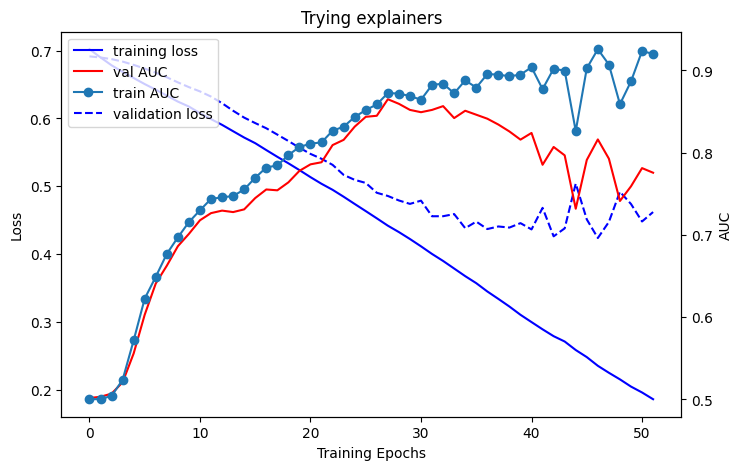

In [181]:
train_params = {
    'weight_decay': 1e-3,
    'lr': 0.001,
    'epochs':400,
    "patience":5,
    "delta":0.01,
    "supervision_types":[('author', 'to', 'paper')]
}
trained_model, auc = launch_experiment(dblp_model,train_data,val_data,train_params)

In [182]:
full_test(dblp_model,val_data,train_params["supervision_types"],200,False)

{('author', 'to', 'paper'): [0.78, 0.7, 0.78, 197.0]}

In [55]:
pred = torch.round(dblp_model(train_data,[("user", "rates", "movie")])[("user", "rates", "movie")])
ground_truth = train_data.edge_label_dict[("user", "rates", "movie")]

In [57]:
train_data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 80670],
    edge_label=[80670],
    edge_label_index=[2, 80670]
  },
  (movie, rev_rates, user)={ edge_index=[2, 80670] }
)